# 209 Figure 2

Making Figure 2.

In [1]:
import pyam
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D 
from matplotlib.patches import Patch
import matplotlib.transforms as mtransforms

from pathlib import Path

<IPython.core.display.Javascript object>

Step 1: Read in the necessary emission files.

In [2]:
ren_provide = pyam.IamDataFrame(
    Path(
        'processed_data/206_ren_nzco2_emi.xlsx'
    )
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file processed_data/206_ren_nzco2_emi.xlsx
pyam.core - INFO: Reading meta indicators


In [3]:
ren_provide_adapted = pyam.IamDataFrame(
    Path(
        'processed_data/203_ren_emissions.csv'
    )
)

pyam.core - INFO: Reading file processed_data/203_ren_emissions.csv


Step 2: Create an aggregate emission variable for the `ren_provide_adapted` dataframe.

In [4]:
ren_provide_adapted_co2 = ren_provide_adapted.aggregate(
    variable='Emissions|CO2',
    components=[
        'Emissions|CO2|Energy and Industrial Processes',
        'Emissions|CO2|AFOLU'
    ]
)

Step 3: Convert the unit for the original dataframe.

In [5]:
ren_provide_co2 = (
    ren_provide
    .filter(
        variable='Emissions|CO2'
    )
    .convert_unit(
        current='Eg C/yr',
        to='Gt CO2/yr'
    )
)

In [6]:
ren_provide_adapted_co2.convert_unit(
    current='Mt CO2/yr',
    to='Gt CO2/yr',
    inplace=True
)

Step 4: Read in the temperature related data for the adapted scenarios.

In [7]:
temp_provide_adapted_co2 = pyam.IamDataFrame(
    Path(
        'processed_data/205_temperatures.csv'
    )
)

pyam.core - INFO: Reading file processed_data/205_temperatures.csv


Step 5: Swap time for year

In [8]:
temp_provide_adapted_co2.swap_time_for_year(inplace=True)

Step 6: Pull out the temperatures for the original run

In [9]:
temp_provide = (
    ren_provide
    .filter(
        variable='Emissions|CO2',
        keep=False
    )
)

Step 7: Read in the metrics dataframe

In [10]:
df_metrics = pd.read_csv(
    Path(
        'processed_data/207_fair_nnce_estimates.csv'
    )
)

Step 8: Read in the nnce estimates using WG1-based estimates.

In [11]:
nnce_wg1_tcre = np.load(
    Path(
        'processed_data/202_nnce_tcre.npy'
    )
)

In [12]:
nnce_wg1_zec = np.load(
    Path(
        'processed_data/202_nnce_zec.npy'
    )
)

Step 9: Read in the WG3 scenarios metadata.

In [13]:
wg3_scenario_meta = pd.read_excel(
    Path(
        '../data/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx'
    ),
    sheet_name='meta'
)

Step 10: Define the figure and plot it

In [14]:
def plot_median_very_likely_range(
    df,
    ax,
    color,
    alpha,
    plot_full=False
):
    """plot the temperature"""
    ts = df.timeseries()
    x_vals = ts.columns
    # Determine median and very likely range
    median = ts.median()
    p5 = ts.quantile(q=0.05)
    p95 = ts.quantile(q=0.95)
    ax.plot(
        median,
        color=color,
        alpha=alpha
    )
    if plot_full:
        ax.plot(
            ts.max(),
            color=color,
            linestyle='dashed',
            alpha=alpha
        )
    else:
        ax.plot(
            p95,
            color=color,
            linestyle='dashed',
            alpha=alpha
        )

Make a scenario and color map - this will be helpful (I guess)

In [15]:
color_map = {
    'Ren_NZCO2_5': 'grey',#'#83d0e2',
    'Ren_NZCO2_10': 'grey', #'#7688ab',
    'Ren_NZCO2_15':'grey', #'#4dbdab',
    'Ren_NZCO2_20':'#e74d4d',
    'Ren_NZCO2_25': 'grey'#'#a5917f'
}

In [16]:
data = df_metrics.loc[:,'nnce_total']

In [17]:
plt.rcParams.update({'font.size': 15})

In [18]:
pos = df_metrics[df_metrics['2060']>1.5]

In [19]:
# Thanks https://stackoverflow.com/questions/18386210/annotating-ranges-of-data
def rotate_point(x, y, angle_rad):
    cos,sin = np.cos(angle_rad),np.sin(angle_rad)
    return cos*x-sin*y,sin*x+cos*y

def draw_brace(ax, span, position, text, text_pos, brace_scale=1.0, beta_scale=300., rotate=False, rotate_text=False):
    '''
        all positions and sizes are in axes units
        span: size of the curl
        position: placement of the tip of the curl
        text: label to place somewhere
        text_pos: position for the label
        beta_scale: scaling for the curl, higher makes a smaller radius
        rotate: true rotates to place the curl vertically
        rotate_text: true rotates the text vertically        
    '''
    # get the total width to help scale the figure
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin
    resolution = int(span/xax_span*100)*2+1 # guaranteed uneven
    beta = beta_scale/xax_span # the higher this is, the smaller the radius
    # center the shape at (0, 0)
    x = np.linspace(-span/2., span/2., resolution)
    # calculate the shape
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    # put the tip of the curl at (0, 0)
    max_y = np.max(y)    
    min_y = np.min(y)
    y /= (max_y-min_y)
    y *= brace_scale
    y -= max_y
    # rotate the trace before shifting
    if rotate:
        x,y = rotate_point(x, y, np.pi/2)
    # shift to the user's spot   
    x += position[0]        
    y += position[1]
    ax.autoscale(False)
    ax.plot(x, y, color='grey', lw=1, clip_on=False)
    # put the text
    ax.text(text_pos[0], text_pos[1], text, fontsize=12, color='grey', ha='left', va='bottom', rotation=90 if rotate_text else 0)

/Users/gauravganti/opt/anaconda3/envs/provide_perspective/lib/python3.10/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
/Users/gauravganti/opt/anaconda3/envs/provide_perspective/lib/python3.10/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
/Users/gauravganti/opt/anaconda3/envs/provide_perspective/lib/python3.10/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
/Users/gauravganti/opt/anaconda3/envs/provide_perspective/lib/python3.10/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
/Users/gauravganti/o

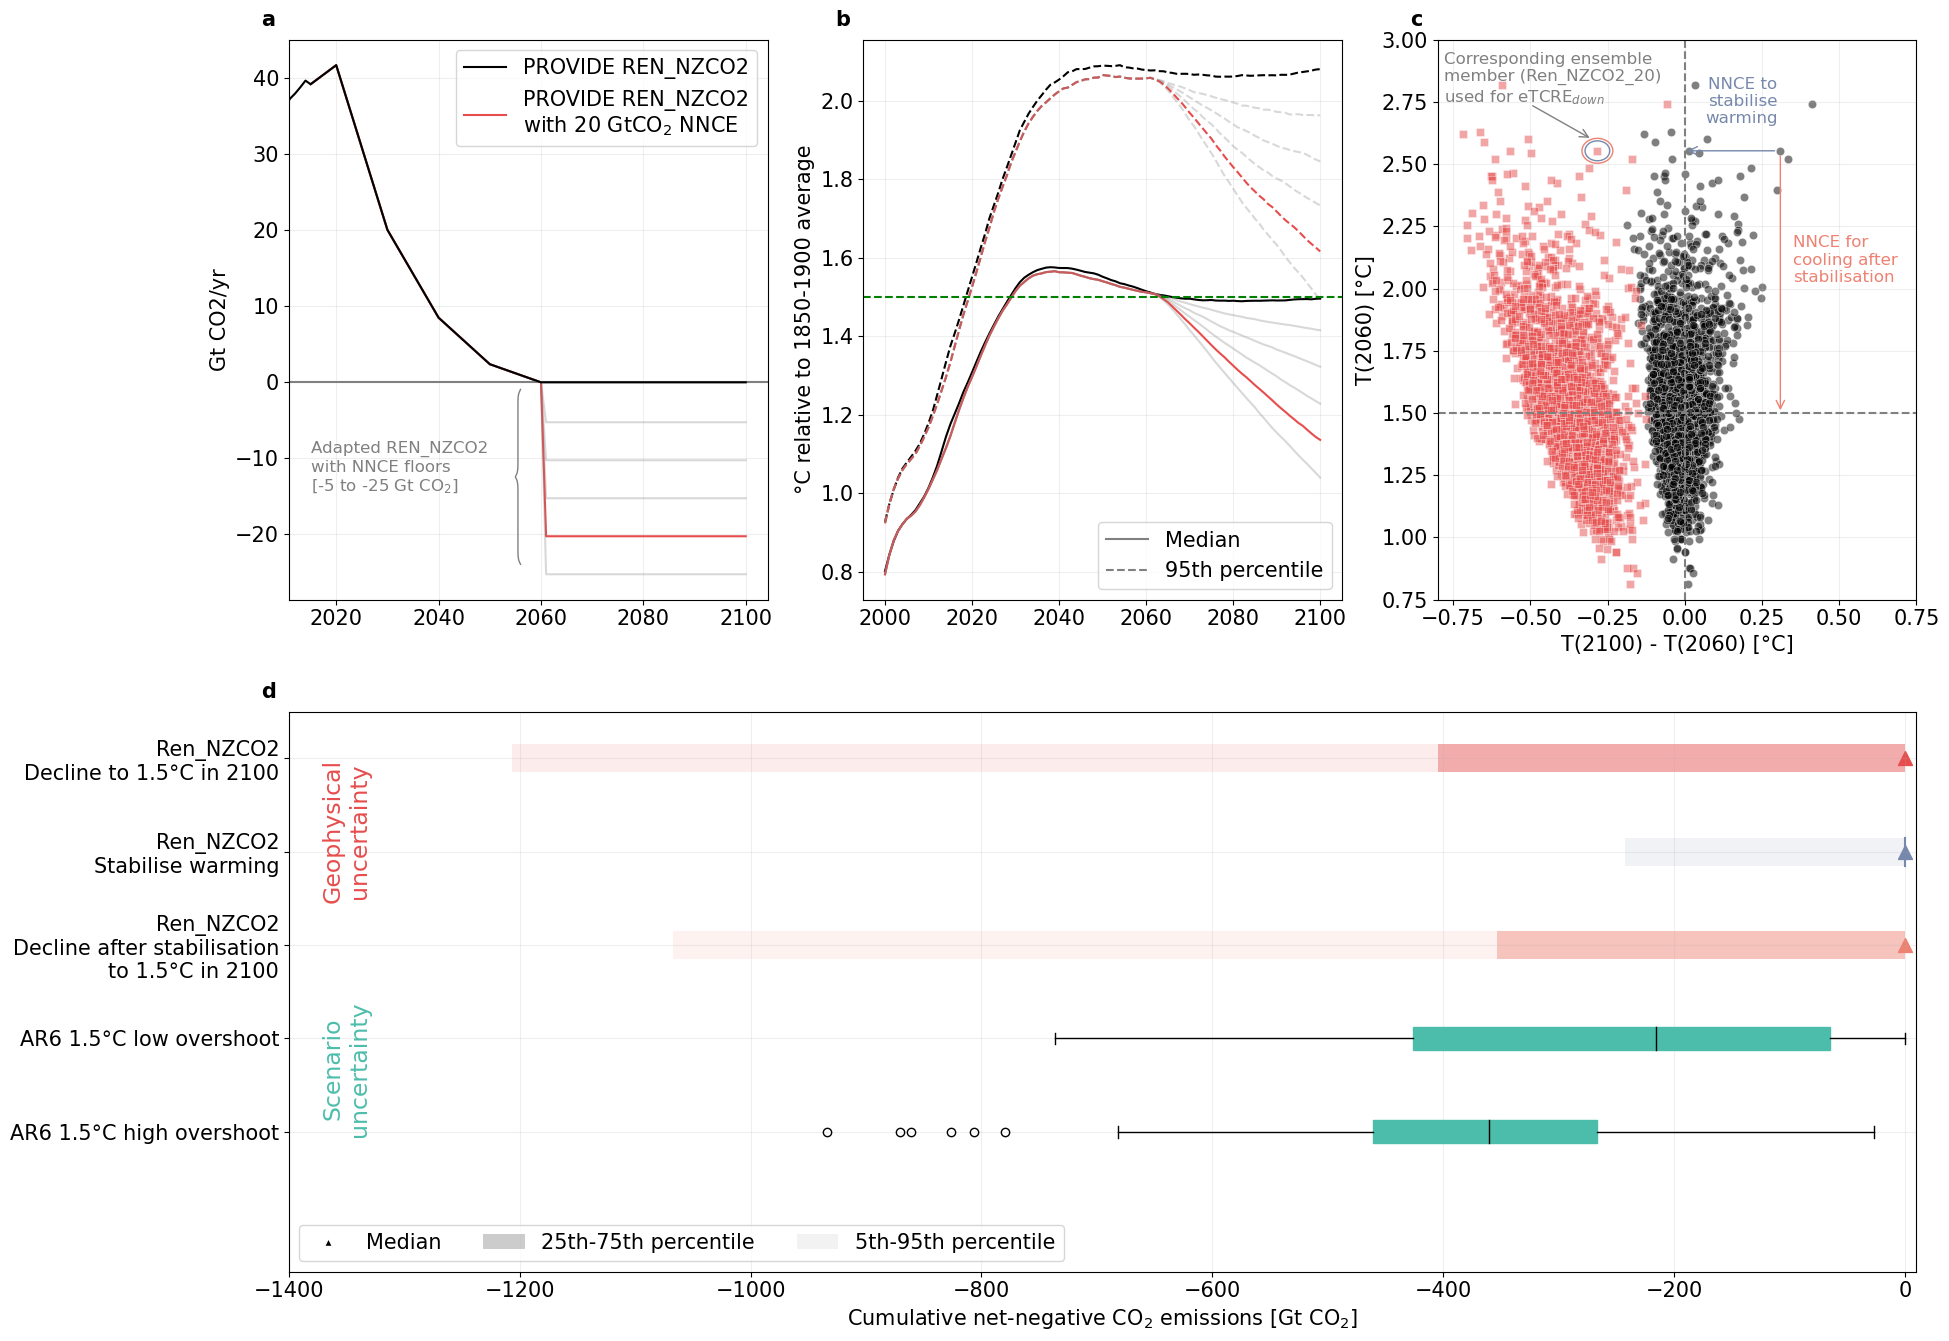

In [20]:
fig,ax = plt.subplot_mosaic(
    [['a', 'b','c'],
    ['d', 'd', 'd']],
    figsize=(21, 16)
)

# Panel a - plot the emissions
## First plot all the scenarios
for scenario in color_map.keys():
    if color_map[scenario]=='grey':
        alpha=0.3
    else:
        alpha=1
    plot_data = (
        ren_provide_adapted_co2
        .filter(
            scenario=scenario
        )
    )
    plot_data.plot(
        ax=ax['a'],
        color=color_map[scenario],
        alpha=alpha
    )

ax['a'].axhline(0, color='grey')

# Now let us add an annotation for the adapted scenarios

draw_brace(
    ax=ax['a'],
    span=23,
    position=(2055, -12.5),
    text='Adapted REN_NZCO2\nwith NNCE floors\n[-5 to -25 Gt CO$_2$]',
    text_pos=(2015, -15),
    rotate=True
)


#ax.annotate('SDL', xy=(0.5, 0.90), xytext=(0.5, 1.00), xycoords='axes fraction', 
#            fontsize=fs*1.5, ha='center', va='bottom',
#            bbox=dict(boxstyle='square', fc='white', color='k'),
#            arrowprops=dict(arrowstyle='-[, widthB=7.0, lengthB=1.5', lw=2.0, color='k'))

# Next, plot
ren_provide_co2.plot(
    ax=ax['a'],
    color='black'
)

# We now make a custom legend - this will include only three entries
legend_labels = [
    Line2D([0], [0], color='black', label='PROVIDE REN_NZCO2'),
    Line2D([0], [0], color='#e74d4d', label='PROVIDE REN_NZCO2\nwith 20 GtCO$_2$ NNCE')
]

ax['a'].legend(handles=legend_labels)
ax['a'].set_title('')
ax['a'].set_xlabel('')

# Add annotation for the panel

# Panel b - plot the temperatures
plot_median_very_likely_range(
    temp_provide,
    ax['b'],
    'black',
    alpha=1,
    plot_full=False
)
for scenario in color_map.keys():
    if color_map[scenario]=='grey':
        alpha=0.3
    else:
        alpha=1
    plot_median_very_likely_range(
        temp_provide_adapted_co2.filter(
            scenario=scenario,
            year=range(2000, 2101)
        ),
        ax['b'],
        color_map[scenario],
        alpha=alpha,
        plot_full=False
    )

ax['b'].axhline(1.5, color='green', linestyle='dashed')

# Panel c
sns.scatterplot(
    y='2060',
    x='ezec',
    data=df_metrics,
    color='black',
    ax=ax['c'],
    alpha=0.5
)
sns.scatterplot(
    y='2060',
    x='delta_t_2100_2060',
    data=df_metrics,
    color='#e74d4d',
    ax=ax['c'],
    marker='s',
    alpha=0.5
)

# Now pull out the dot to highlight
point_to_highlight = (
    df_metrics[(
        df_metrics.loc[:,'ezec']>0.3) 
        & 
        (df_metrics.loc[:,'ezec']<0.31)
    ]
)

# Now, we first add the horizontal line
ax['c'].annotate(
    text='',
    xy=(0.3, point_to_highlight['2060']),
    xytext=(0, point_to_highlight['2060']),
    arrowprops=dict(
        arrowstyle='<-',
        color='#7688ab'
    )
)
ax['c'].text(
    x=0.30,
    y=point_to_highlight['2060']+0.11,
    s='NNCE to\nstabilise\nwarming',
    fontsize=12,
    color='#7688ab',
    ha='right'
)

ax['c'].annotate(
    text='',
    xy=(0.3096, point_to_highlight['2060']-0.01),
    xytext=(0.3096, 1.5),
    arrowprops=dict(
        arrowstyle='<-',
        color='#ee8172'
    )
)

ax['c'].text(
    x=0.35,
    y=(point_to_highlight['2060']+1.5)/2,
    s='NNCE for\ncooling after\nstabilisation',
    fontsize=12,
    color='#ee8172',
    ha='left'
)

circ1 = plt.Circle(
    (point_to_highlight['delta_t_2100_2060'], point_to_highlight['2060']),
    0.04,
    color='#7688ab',
    fill=False
)

circ2 = plt.Circle(
    (point_to_highlight['delta_t_2100_2060'], point_to_highlight['2060']),
    0.05,
    color='#ee8172',
    fill=False
)

ax['c'].add_patch(circ1)
ax['c'].add_patch(circ2)

ax['c'].text(
    x=-0.78,
    y=2.75,
    s='Corresponding ensemble\nmember (Ren_NZCO2_20)\nused for eTCRE$_{down}$',
    fontsize=12,
    color='grey'
)

ax['c'].annotate(
    text='',
    xy=(-0.3, 2.6),
    xytext=(-0.5, 2.74),
    arrowprops=dict(
        arrowstyle='->',
        color='grey'
    )
)

ax['c'].set_xlim(-0.8, 0.75)
ax['c'].set_ylim(0.75, 3)
# Panel d
## First, let us plot the FaIR assessment
color_maps = {
    'nnce_total':'#e74d4d',
    'nnce_pos_zec_comp':'#7688ab',
    'nnce_decline':'#ee8172'
}
for loc, col in enumerate(
    [
        'nnce_total',
        'nnce_pos_zec_comp',
        'nnce_decline'
    ]
):
    data = df_metrics.loc[:,col]
    # Estimate median, interquartile, and very likely range
    stats = data.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
    ax['d'].scatter(
        y=loc,
        x=stats['50%'],
        marker='^',
        color=color_maps[col],
        s=100
    )
    # Plot the IQR
    ax['d'].barh(
        y=loc,
        left=stats['75%'],
        width=stats['25%']-stats['75%'],
        alpha=0.4,
        color=color_maps[col],
        height=0.3
    )
    if stats['25%']==stats['75%']:
        ax['d'].errorbar(
            x=[0, 0],
            y=[loc+0.15, loc-0.15],
            color=color_maps[col]
        )
    # Fourth, let us plot the very likely range
    ax['d'].barh(
        y=loc,
        left=stats['95%'],
        width=stats['5%']-stats['95%'],
        alpha=0.1,
        color=color_maps[col],
        height=0.3
    )

## Finally, we add the WG3 based results
cols={
    'C1':'#4dbdab',
    'C2':'#4dbdab'
}
for j,cat in enumerate(['C1', 'C2']):
    ar6_nnce = wg3_scenario_meta[wg3_scenario_meta['Category']==cat]['Cumulative net-negative CO2 (post net-zero, Gt CO2) (Harm-Infilled)']/1e3
    p = ax['d'].boxplot(
        x=ar6_nnce,
        #positions=[loc+2+j],
        positions=[loc+1+j],
        patch_artist=True,
        vert=False,
        widths=0.25
    )
    plt.setp(p['boxes'], color=cols[cat])
    plt.setp(p['medians'],color='black')
ax['d'].set_ylim(-0.5, 5.5)
ax['d'].invert_yaxis()
#ax['d'].set_yticks(range(6))
ax['d'].set_yticks(range(5))
ytick_labels = [
    'Ren_NZCO2\nDecline to 1.5°C in 2100',
    'Ren_NZCO2\nStabilise warming',
    'Ren_NZCO2\nDecline after stabilisation\nto 1.5°C in 2100',
 #   'AR6 WG1 TCRE\nCooling of 0.1°C',
    'AR6 1.5°C low overshoot',
    'AR6 1.5°C high overshoot'
]
ax['d'].set_yticklabels(ytick_labels)
for s in ['a', 'b', 'c', 'd']:
    ax[s].grid(alpha=0.2)

### Futher annotations and plot formatting ###
ax['b'].set_ylabel(
    '°C relative to 1850-1900 average'
)
custom_legend = [
    Line2D([0], [0], color='grey', label='Median'),
    Line2D([0], [0], color='grey', linestyle='dashed', label='95th percentile'),
]
ax['b'].legend(
    handles=custom_legend
)
ax['c'].set_xlabel('T(2100) - T(2060) [°C]')
ax['c'].set_ylabel('T(2060) [°C]')
ax['c'].axvline(0, color='grey', linestyle='dashed')
ax['c'].axhline(1.5, color='grey', linestyle='dashed')
common_args = {
    'color':'black',
    #'alpha':0.5,
    'ha':'center',
    'va':'top',
    'transform':ax['c'].transAxes,
    'fontsize':12,
}

#ax['c'].text(0.1, 0.99, 'I',**common_args)
#ax['c'].text(0.9, 0.99, 'II', **common_args)
#ax['c'].text(0.1, 0.1, 'III',**common_args)
#ax['c'].text(0.9, 0.1, 'IV', **common_args)
#ax['c'].set_xlim(-0.8, 0.6)



ax['d'].set_xlim(
    -1400, 
    10
)

ax['d'].text(
    x=-1350,
    y=1.5,
    s='Geophysical\nuncertainty',
    rotation=90,
    color='#e74d4d',
    ha='center',
    fontsize=17
)


ax['d'].text(
    x=-1350,
    y=4,
    s='Scenario\nuncertainty',
    rotation=90,
    color='#4dbdab',
    ha='center',
    fontsize=17
)

ax['d'].set_xlabel(
    'Cumulative net-negative CO$_2$ emissions [Gt CO$_2$]'
)

custom_legend = [
    Line2D([0], [0], color='w', marker='^', markerfacecolor='black', label='Median'),
    Patch(facecolor='grey', alpha=0.4, label='25th-75th percentile'),
    Patch(facecolor='grey', alpha=0.1, label='5th-95th percentile')
]
ax['d'].legend(handles=custom_legend, ncol=3)
#ax['d'].axvline(0, color='grey', alpha=0.7)

for label, ax in ax.items():
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
             va='bottom', weight='bold')

Step 11: Save the figure

In [21]:
fig.savefig(
    Path(
        'figures/fig2.jpg'
    ),
    dpi=1000,
    bbox_inches='tight'
)